## Data Preprocessing

In [184]:
######importing libraries for data manipulation#######
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gzip
import math
from PIL import Image
import requests
from io import BytesIO

In [360]:
###############Function definitions###########

#########Function definitions for separating related feature########
def change_vals_new_col(s,value,new_cols):
    
    if(value.get(s) != None):
        if((type(value[s]) == float) and np.isnan(value[s])):
            new_cols[s] = np.nan
        else:
            new_cols.get(s).append(value[s])
    else:
        new_cols.get(s).append(np.nan)
    

def generate_new_cols(related):
    
    new_cols = {'also_bought':[], 'also_viewed':[],'bought_together':[],'buy_after_viewing':[]}
    
    for key,value in related.items():
        if((type(value) == float) and np.isnan(value)):
            
            new_cols['also_bought'].append(np.nan)
            new_cols['also_viewed'].append(np.nan)
            new_cols['bought_together'].append(np.nan)
            new_cols['buy_after_viewing'].append(np.nan)
        else:
            change_vals_new_col('also_bought',value,new_cols)
            change_vals_new_col('also_viewed',value,new_cols)
            change_vals_new_col('bought_together',value,new_cols)
            change_vals_new_col('buy_after_viewing',value,new_cols)
            
        
    return new_cols
#####Function definitions for separating related feature ends####

def plot_related_prods(related,which,final_metadata):
    
    if(related == None):
        print('People who'+str(related)+'this product did not buy any other product:')
        return
    else:
        #print(np.array(related) in final_metadata.index)
        tot = 0
        for idx in related:
            if(idx in final_metadata.index):
                tot += 1
        print(tot)
        tot = round(tot/2)
        print('final',tot)
        f, axes = plt.subplots(tot,tot,figsize=(4,4),dpi=300)
        f.suptitle('People also '+str(which))
        for i in range(0,tot):
            for j in range(0,tot):
                curr_asin = related[i+j]
                if((curr_asin in final_metadata.index) == True):
                    curr_url = final_metadata.loc[curr_asin]['imUrl']
                    curr_title = final_metadata.loc[curr_asin]['title']
                    curr_title = curr_title[0:30]
                    response = requests.get(curr_url)
                    img = Image.open(BytesIO(response.content))
                    axes[i,j].imshow(img)
                    axes[i,j].get_xaxis().set_ticks([])
                    axes[i,j].get_yaxis().set_ticks([])
                    plt.axis('off')
                    axes[i,j].set_title(curr_title,size=3)
        plt.show()            

def Show_related_products(meta_data_row,final_metadata):
    
    #print(meta_data_row)
    curr_url = meta_data_row['imUrl']
    #curr_prod_id = meta_data_row['asin']
    title = meta_data_row['title']
    
    print('The current product is:',title)
    response = requests.get(curr_url)
    img = Image.open(BytesIO(response.content))
    plt.imshow(img)
    plt.show()
    
    ####People who bought this product also bought####
    also_bought = meta_data_row['also_bought']
    if((type(also_bought) == float) and np.isnan(also_bought)):
        also_bought = None
    else:
        if(len(also_bought) > 9):
            also_bought = also_bought[0:9]
    plot_related_prods(also_bought,'bought',final_metadata)
    
    ####People who bought this product also viewed####
    also_viewed = meta_data_row['also_viewed']
    if((type(also_viewed) == float) and np.isnan(also_viewed)):
        also_viewed = None
    else:
        if(len(also_viewed) > 9):
            also_viewed = also_viewed[0:9]
    plot_related_prods(also_viewed,'viewed',final_metadata)


    

### Read Data In

In [186]:
#####Reading Data#######
#####This is a smaller data for initial data exploration and model testing#####
######The data is about Heal and Personal care Products on Amazon##########

def parse(path):
    g = open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

data_path = '/Users/ruchinpatel/Desktop/USC_EVERYTHING/SPRINGBOARD/CAPSTONE/Health_and_Personal_Care_5.json'
metadata_path = '/Users/ruchinpatel/Desktop/USC_EVERYTHING/SPRINGBOARD/CAPSTONE/meta_Health_and_Personal_Care.json'

data = getDF(data_path)
metadata = getDF(metadata_path)

* As seen from the table above the field related has two sub values $\textbf{also_bought}$ and $\textbf{also_viewed}$ and as a result of this we need to make two new columns for it.

In [187]:
########## Generating seperate columns for related feature######
related = metadata['related'].to_dict()
newly_created_columns = pd.DataFrame(generate_new_cols(related))

In [223]:
#########Final Metadata dataframe###########
final_metadata = pd.concat([metadata,newly_created_columns],axis = 1)
final_metadata = final_metadata.drop('related',axis=1)
final_metadata = final_metadata.set_index('asin')

######converting the dates to date time format#####
data['unixReviewTime'] = pd.to_datetime(data['unixReviewTime'],unit='s')
data['reviewTime'] = pd.to_datetime(data['reviewTime'])


In [224]:
data.head(5)

reviewerID        asin                reviewerName   helpful  \
0   ALC5GH8CAMAI7  159985130X                        AnnN    [1, 1]   
1   AHKSURW85PJUE  159985130X         AZ buyer "AZ buyer"    [1, 1]   
2   A38RMU1Y5TDP9  159985130X  Bob Tobias "Robert Tobias"  [75, 77]   
3  A1XZUG7DFXXOS4  159985130X                   Cat lover  [56, 60]   
4  A1MS3M7M7AM13X  159985130X                  Cricketoes    [1, 1]   

                                          reviewText  overall  \
0  This is a great little gadget to have around. ...      5.0   
1  I would recommend this for a travel magnifier ...      4.0   
2  What I liked was the quality of the lens and t...      4.0   
3  Love the Great point light pocket magnifier!  ...      4.0   
4  This is very nice. You pull out on the magnifi...      5.0   

                                 summary unixReviewTime reviewTime  
0                    Handy little gadget     2011-01-05 2011-01-05  
1  Small & may need to encourage battery     2012-02-18 2012-02-18  
2                Very good but not great     2010-06-08 2010-06-08  
3           great addition to your purse     2008-02-08 2008-02-08  
4              Very nice and convenient.     2011-08-16 2011-08-16

In [356]:
final_metadata

description  \
asin                                                            
0077614992            This is an example product description.   
0615208479  By now we all know the benefits of exercise fo...   
0615269990  What's wrong with your patient?Do all the symp...   
0615315860                                                NaN   
0615406394            This is an example product description.   
0615836828                                                NaN   
0641710577  Foster Grant introduces a whole new dimension ...   
0641864507  * Super bright LED light\n    * 2 CR2016 repla...   
0681504498  Affordably priced. Hardcover or paper back, th...   
0705394638  Beautiful memory book for you new baby boy to ...   
0736789928  The Zaner-Bloser Classic Pen is modeled on the...   
076493211X  Twenty 5 x 7" blank notecards (five each of fo...   
0767196767  For the busy woman on-the-go&#x2026; our purse...   
0767196813  For the busy woman on-the-go&#x2026; our purse...   
0895640163            This is an example product description.   
0898004640  White peacock gift wrapping paper, twelve (12)...   
0898004659  Peacock gift wrapping paper, twelve (12) sheet...   
0898004667  Peacock gift wrapping paper, twelve (12) sheet...   
0929619730  Contains Organic Cold-Milled Flaxseed\nValuabl...   
093926322X  A New film of THE ANCIENT LOVER. Karma Sutra o...   
0945523181  Canoodling is an intimate and hot card game fo...   
0972433503  Ionic Yoga is a guided relaxation CD designed ...   
0974959200  Nutrition Basics, Weight LOss, Lean Mass & Str...   
0976202107            This is an example product description.   
0978559088  Everyone knows that resveratrol is an amazing ...   
0979047714                                                NaN   
0979679737  Based on the teachings of Charles Filmore, Bet...   
097968191X  A full-size, folding medical reference clipboa...   
0982614926  A step by step guide in creating a joyful life...   
0982828004  &#x2022;Nearly 200 Pharmaceutical Compounds re...   
...                                                       ...   
B00LH83AQU                                                NaN   
B00LHG8JBS                                                NaN   
B00LHQJWHI  The device uses ultrasonic pulses, creating ul...   
B00LI8MW7W  When youre caught snogging on the front porch,...   
B00LI94670  Cum n get it! Anytime day or night I'll be wai...   
B00LIASY0Y  Pure Body Nutra has combined the fat burning p...   
B00LIABPW8  The Icy Cool Roller reduces swelling, inflamma...   
B00LIE8SBA                                                NaN   
B00LJBMCKK  Lose Weight Fast and Safely with Premium Natur...   
B00LJBMCFA  Lose Weight Fast and Safely with Premium Natur...   
B00LJUIQJM  Enhance your sex life with bondage! This sex g...   
B00LK1OHES                                                NaN   
B00LK3FHM2  INA 2 is the new and improved version of LELOs...   
B00LLKJCHK  The New Aid Personal Sound Hearing Amplifier A...   
B00LLKFMA6  The souring sound personal sound hearing ampli...   
B00LLXE2MW  Why THIS Formula WORKSDNA Formula's REAL ENERG...   
B00LMFTIOQ  With so many difficulties arising from prescri...   
B00LNIW1EQ  NuNutrients is proud to offerBrilliant HD - De...   
B00LNS2HKY  Product Descriptions:1. Automatic up and down ...   
B00LOZNF7U  Basic Vibrating Cock Ring Category: Vibrating ...   
B00LRKOGDY  Inside this amazing set is a 6/8" round point ...   
B00LT21YXA  Semacore - More Sperm, Better Orgasms THE SPER...   
B00LT9FXAS  Czar Muscle 90 Caps is an advanced bodybuildin...   
B00LTA1XT2  8 for MEN: is specifically formulated to targe...   
B00LU9TWEU  VEEP is a rethink of nutrition. It is not base...   
B00LUCJRYC                                                NaN   
B00LU4MI0A  Extreme Results with Little Effort!\n\nVigrXtr...   
B00LV4480W  The popularity of Garcinia Cambogia has soared...   
B00LWTTO0A  Detox Fit and Slim  body wrap 8pcs and 2 wraps...   
B00LYPUPZK  **Low Pr

### Data Exploration

In [226]:
print(data.info())
print('Total data points:',data.shape[0])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 346355 entries, 0 to 346354
Data columns (total 9 columns):
reviewerID        346355 non-null object
asin              346355 non-null object
reviewerName      343304 non-null object
helpful           346355 non-null object
reviewText        346355 non-null object
overall           346355 non-null float64
summary           346355 non-null object
unixReviewTime    346355 non-null datetime64[ns]
reviewTime        346355 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 26.4+ MB
None
Total data points: 346355


In [336]:
final_metadata.info()
print('Total metadata points:',final_metadata.shape[0])

<class 'pandas.core.frame.DataFrame'>
Index: 263032 entries, 0077614992 to B00LYPUPZK
Data columns (total 11 columns):
description          237839 non-null object
title                262362 non-null object
imUrl                262767 non-null object
salesRank            247665 non-null object
categories           263032 non-null object
price                196043 non-null float64
brand                124304 non-null object
also_bought          120684 non-null object
also_viewed          193140 non-null object
bought_together      118616 non-null object
buy_after_viewing    5160 non-null object
dtypes: float64(1), object(10)
memory usage: 34.1+ MB
Total metadata points: 263032


The current product is: OPTIFAST 800 Vanilla Shake Powder Sachet 1 Carton (7 Packets)


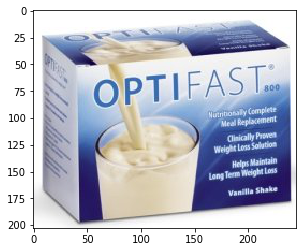

7
final 4


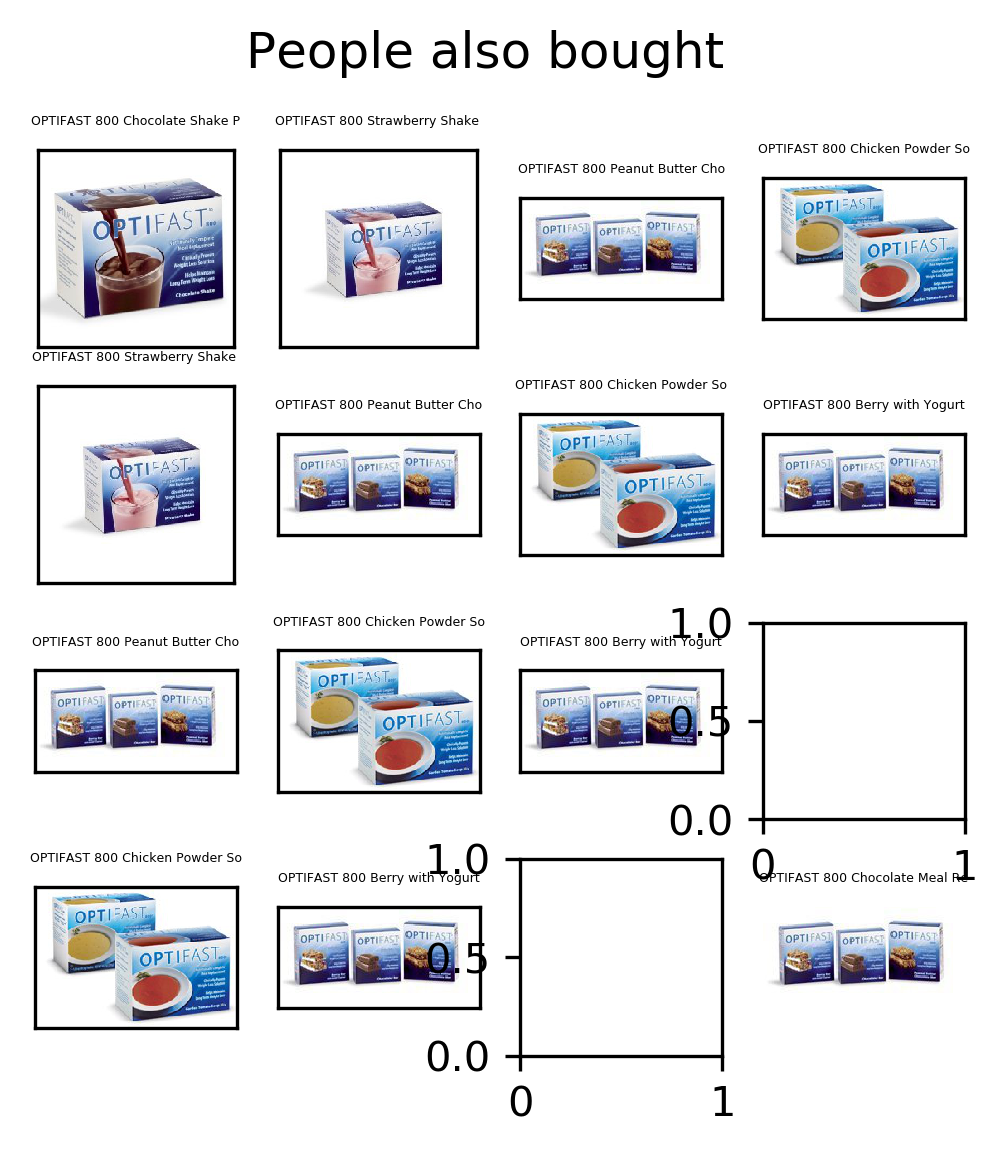

9
final 4


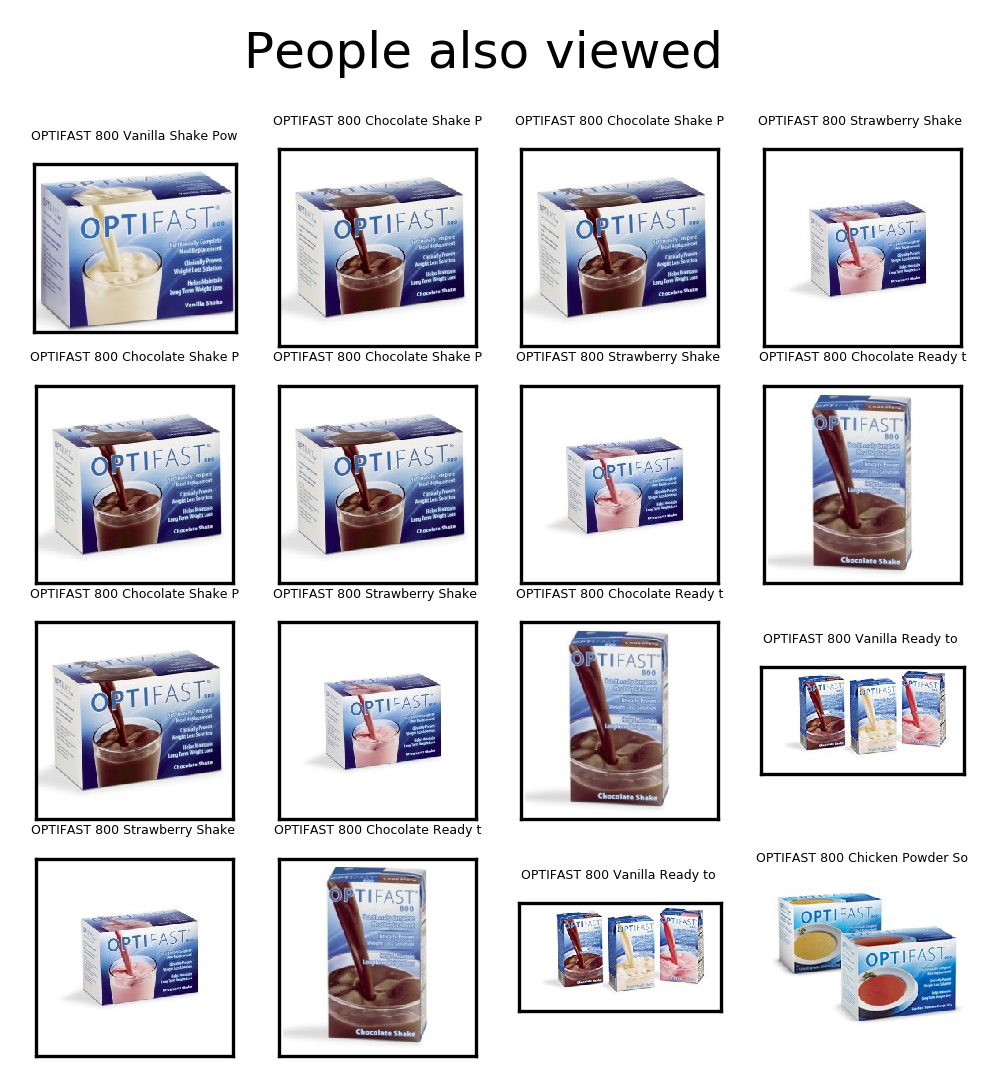

The current product is: Maximum-Strength Adiponectin Activation 400 mg 60 Veg Caps


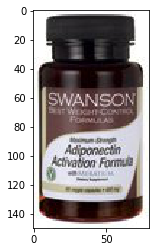

8
final 4


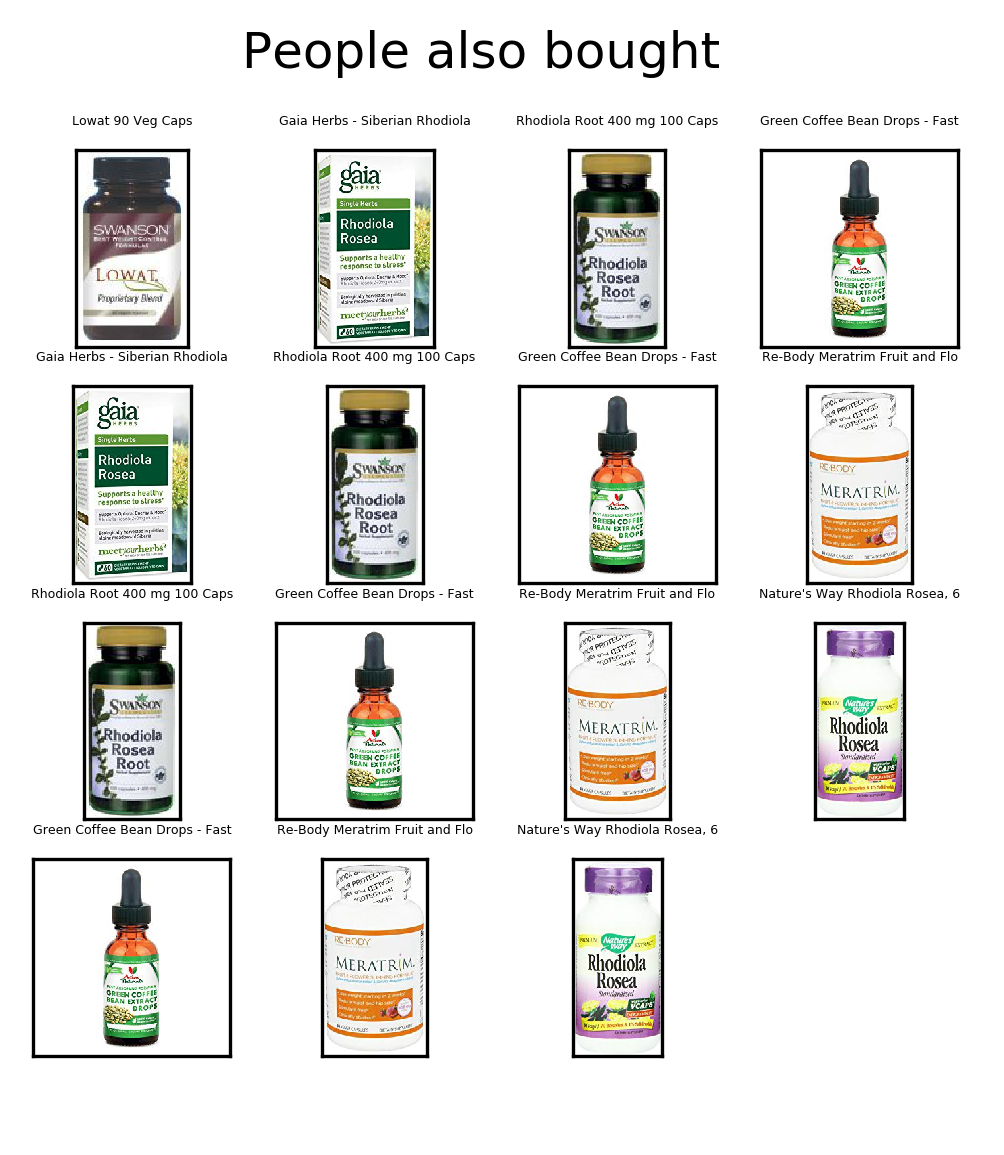

9
final 4


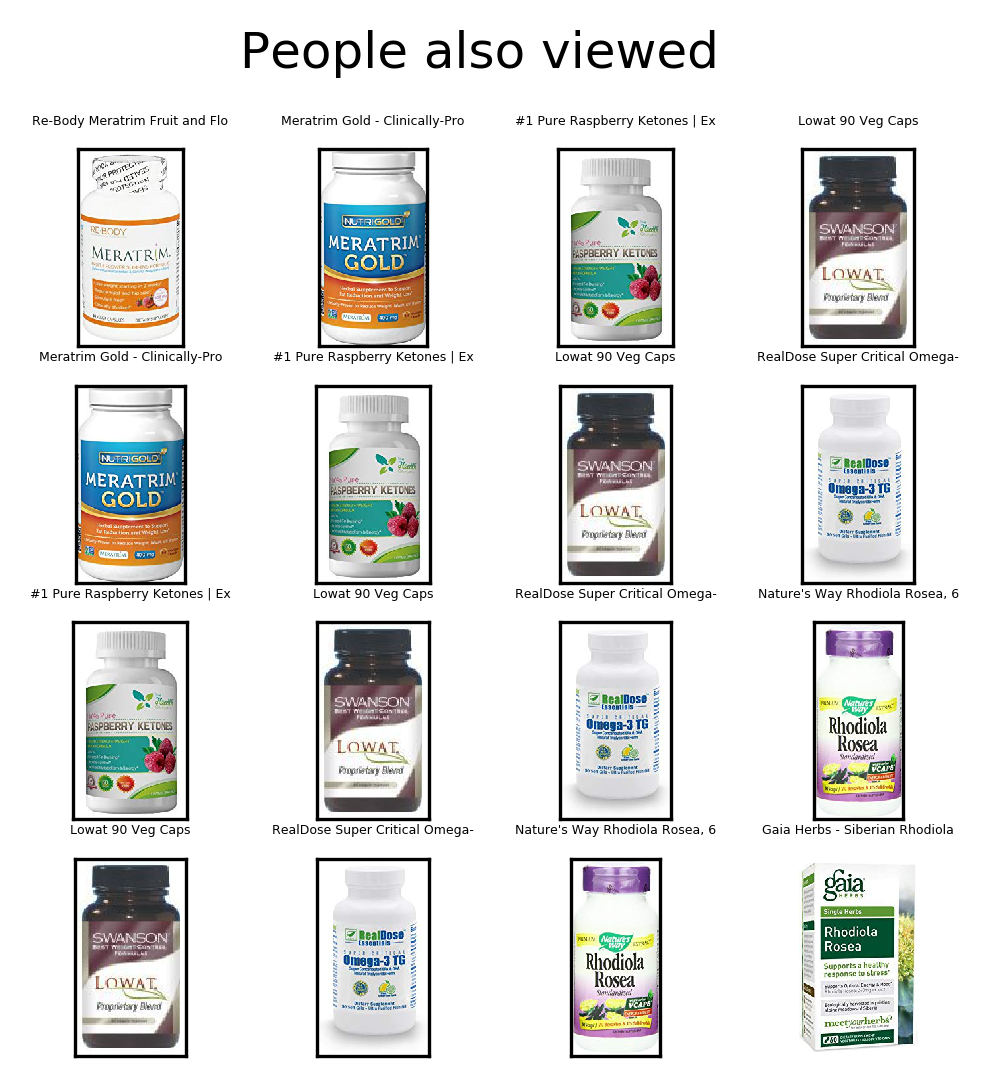

The current product is: NoGii Protein D'Lites Nutritional Bar, Chocolate Caramel Bliss, 18 Count, 1 Oz Bars


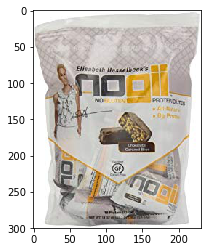

5
final 2


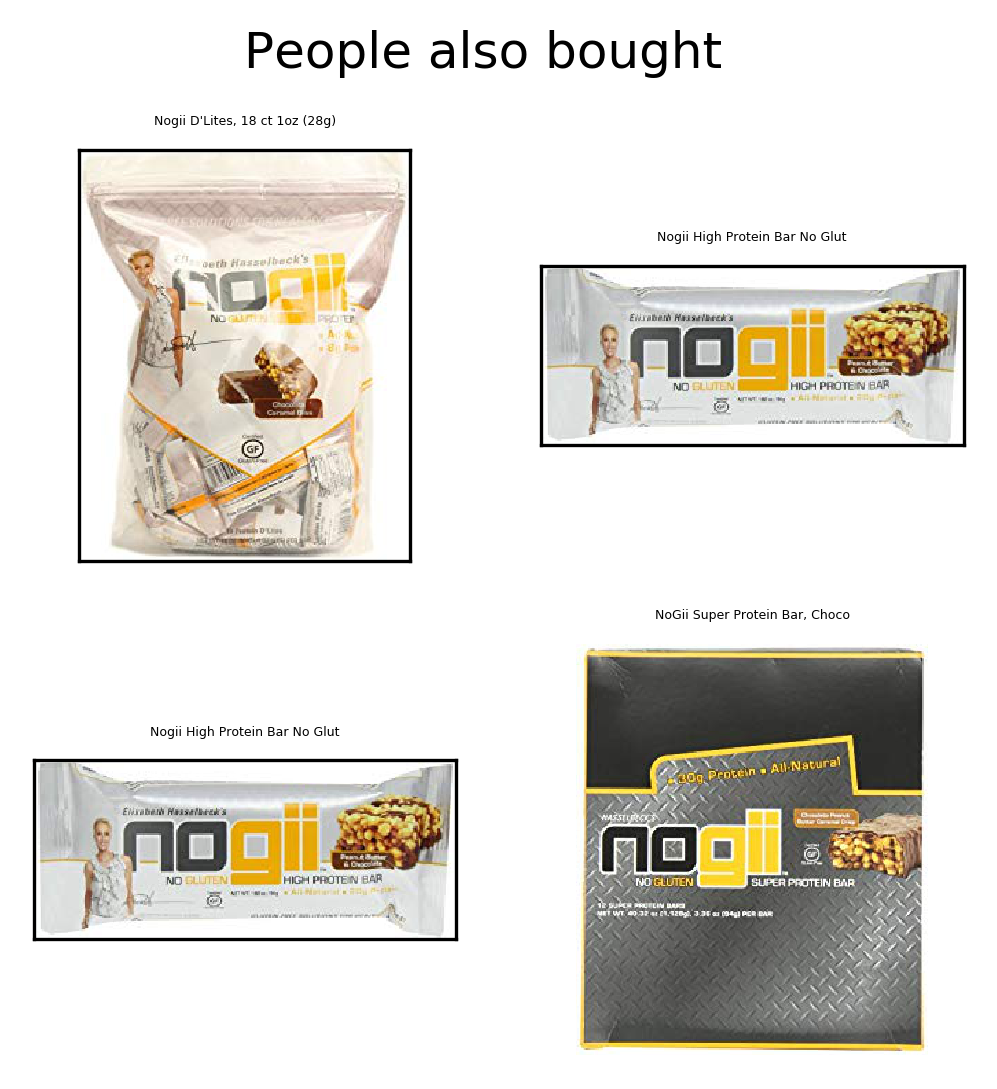

5
final 2


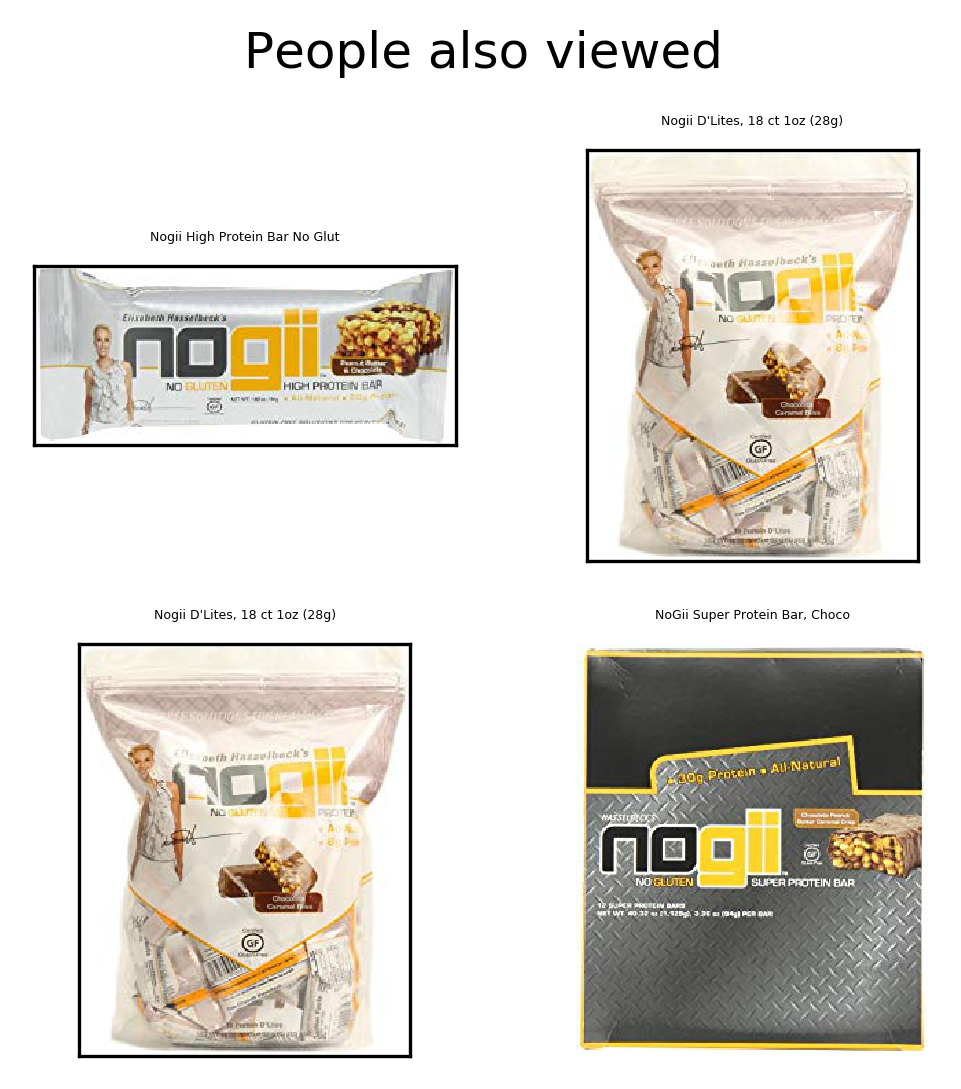

The current product is: Romanoff Deluxe Small Utility Caddy, Hot Pink


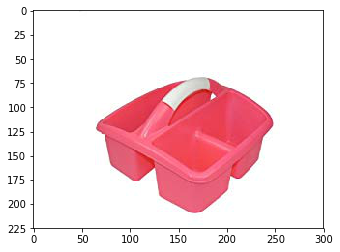

4
final 2


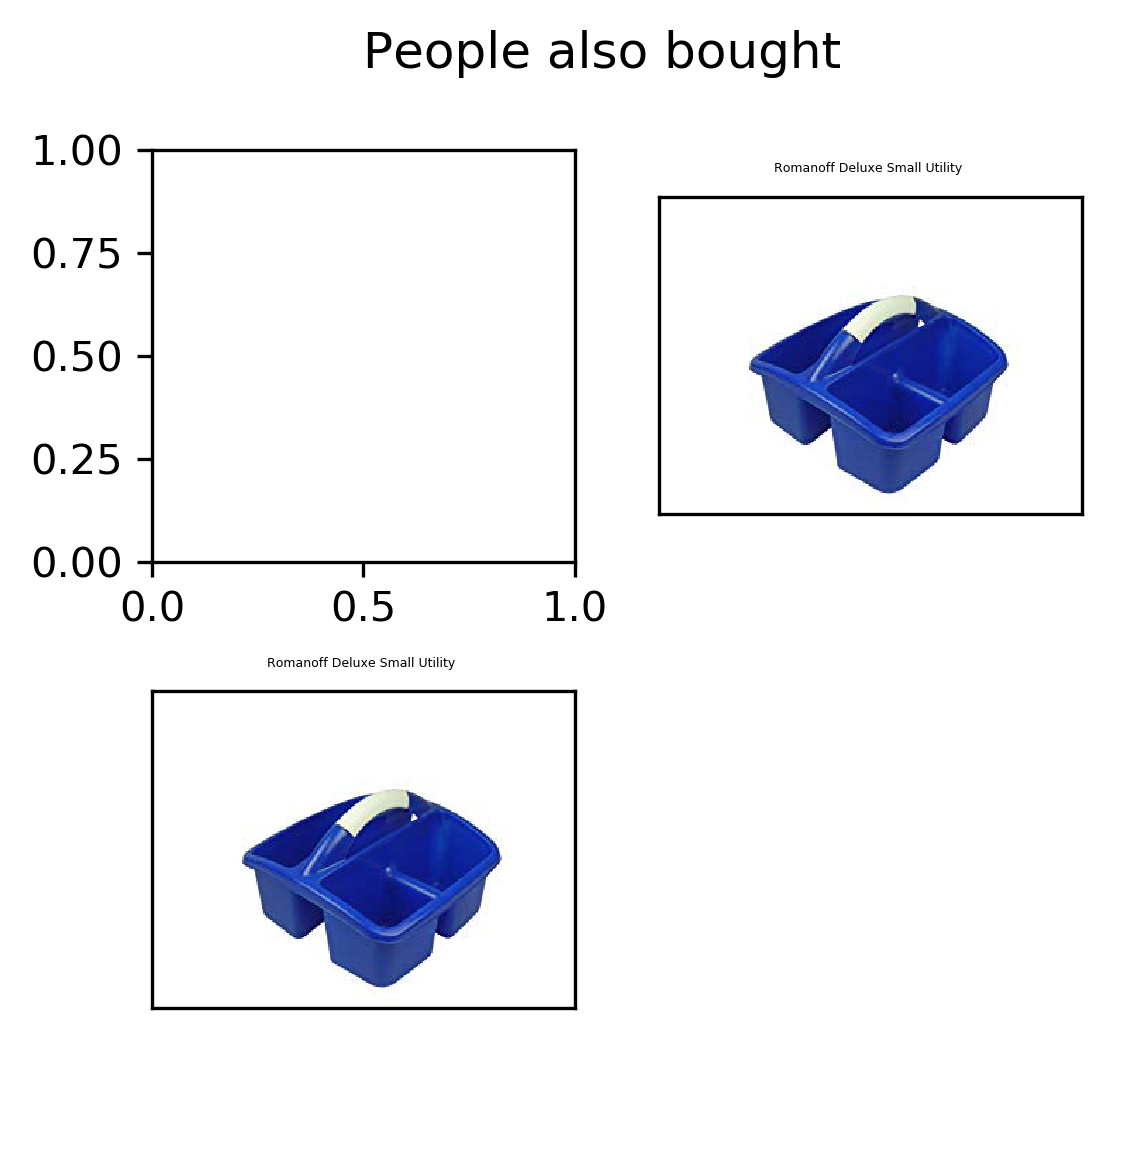

7
final 4


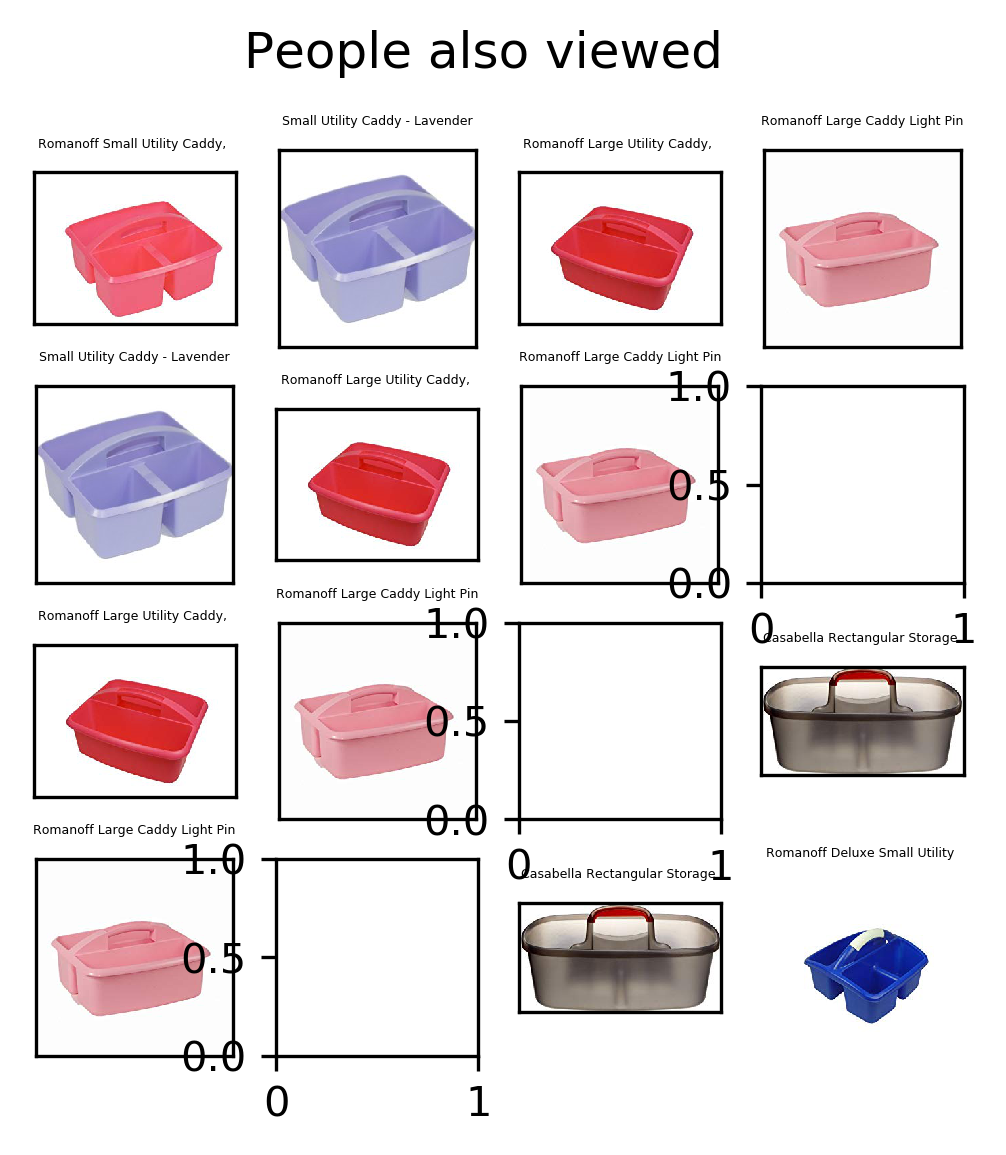

In [361]:
np.random.seed(42)

for i in range(0,4):
    idx = int(np.random.uniform(0,(final_metadata.shape[0]+1)))
    row = final_metadata.iloc[idx,:]
    Show_related_products(row,final_metadata)
    